In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

%matplotlib inline

#from google.colab import drive
#drive._mount('/content/drive')

In [52]:
#read the csv file from GitHb
path = "https://raw.githubusercontent.com/zizhaoguan/cs122_covid19_data/main/data_2/corona_tested_individuals_ver_006.english.csv"
new_df = pd.read_csv(path)

#clean up the data, and make the entries consistent
true_list = ["positive"]
false_list = ["negative"]
new_df = pd.read_csv(
               path,
               na_values=["None", "other"],
               true_values = true_list,
               false_values = false_list
               ).dropna()


change_col_list = ['cough', 'fever', 'sore_throat', 
                   'shortness_of_breath', 'head_ache']

for col in change_col_list:
  new_df[col] = new_df[col].astype('int')
  
new_df["corona_result"] = new_df["corona_result"].astype('bool')


new_df = new_df.drop(["test_date", "test_indication", "gender"]
                     ,axis="columns")


new_df.age_60_and_above = new_df.age_60_and_above.replace(to_replace=['No', 'Yes'], value=[0, 1])


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
try:
  size = int(input("Please choose the size of negative cases(between 10000 ~ 120000)"))
  assert isinstance(size, int) and 9999<size<120001
except AssertionError:
  print("The size should be int and between 10000 and 120000, now it use the defualt size with 120000")
  size = 10626
except ValueError:
  print("Using default value of 10626")
  size = 10626

#10626 is used to make the number of negative and positive cases the same so that the model isn't overfit to one or the other

new_df = new_df.loc[new_df['corona_result'] == False].sample(size).append(new_df.loc[new_df['corona_result'] == True])
new_df

Please choose the size of negative cases(between 10000 ~ 120000)120000


,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above
208221,0,0,0,0,0,False,0
231523,0,0,0,0,0,False,0
253328,1,0,0,0,0,False,0
256282,0,0,0,0,0,False,0
136260,0,0,0,0,0,False,1
...,...,...,...,...,...,...,...
265056,1,1,0,0,0,True,1
265066,1,0,1,0,0,True,0
265100,1,1,0,0,0,True,1
265101,0,0,0,0,0,True,0


**Trying with PCA and Logistic Regression**

In [54]:
X = new_df[new_df.columns.difference(["corona_result"])] #obtain the data
Y = new_df[["corona_result"]] #obtain the label for the data

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25,random_state=7) 

#use the scores and labels to create graph
pca = PCA(n_components=3)
pca.fit(train_x)

test_x_scores = pca.score_samples(test_x).tolist()
test_y_results = test_y['corona_result'].tolist()

'''
#set up the instance of model, sklearn will keep the minimum numbers of components to maintain at least 95% variance
pca = PCA(.95)

#fit the model with training set 
pca.fit(train_x)
'''

#apply dimensionality reduction to trainning set
train_x_transform = pca.transform(train_x)

#apply dimensionality reduction to test set
test_x_transform = pca.transform(test_x)

#create a LogisticRegression model
logisticRegr = LogisticRegression(solver = 'lbfgs')

#the model learns the relationship between the training set and the training label
logisticRegr.fit(train_x_transform, train_y.values.ravel())

#score the model based on the actual label for test set 
print("PCA with LogisticRegression Predition Score:{}".format(logisticRegr.score(test_x_transform, test_y)))

PCA with LogisticRegression Predition Score:0.9175368221208317


In [55]:
#the model predict the lable of the test set
predict_y = logisticRegr.predict(test_x_transform)

print(classification_report(test_y, predict_y))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     29920
        True       0.94      0.02      0.03      2737

    accuracy                           0.92     32657
   macro avg       0.93      0.51      0.50     32657
weighted avg       0.92      0.92      0.88     32657



In [56]:
#save the pca model
dump(pca, 'pca.pkl')

#save the logisticRegr model
dump(logisticRegr, 'logisticRegr.pkl')

['logisticRegr.pkl']

In [57]:
score_df = pd.DataFrame(list(zip(test_y_results, test_x_scores)), columns = ['result', 'score'])
score_df

,result,score
0,False,4.267939
1,False,4.267939
2,False,4.267939
3,False,2.050769
4,False,-1.407327
...,...,...
32652,False,1.180092
32653,False,4.267939
32654,False,2.050769
32655,False,4.267939


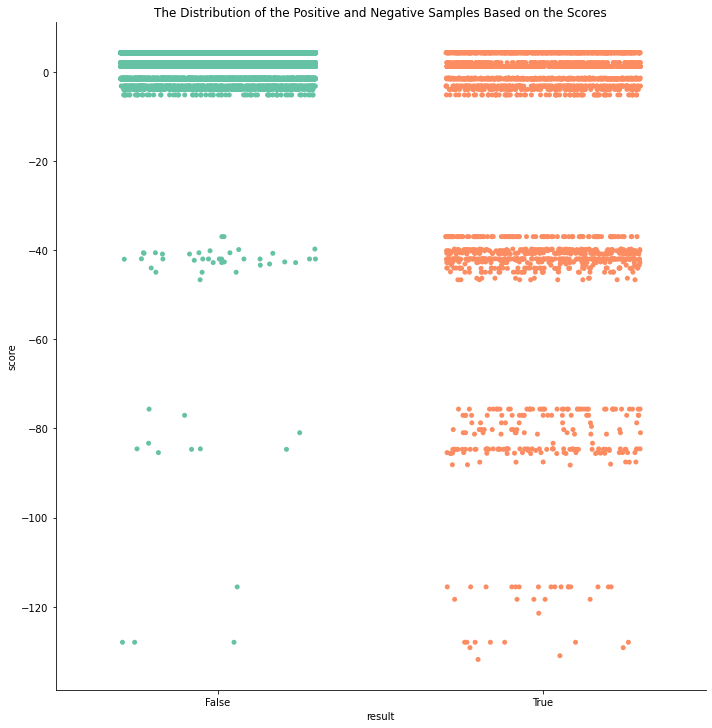

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

#create a catplot to show how the samples are distributed based on the scores
g = sns.catplot(
    data=score_df, 
    x='result',
    y="score",
    aspect=1, # aspect change the aspect ratio
    height=10,
    jitter=0.3, # jitter spread out the data points
    palette="Set2"
    )
plt.title("The Distribution of the Positive and Negative Samples Based on the Scores");

**Try with Adaboost**

In [59]:
adb = AdaBoostClassifier(n_estimators=100,algorithm='SAMME.R',learning_rate=0.1)
adb.fit(train_x, train_y)
predict_y = adb.predict(test_x)

print("Adaboost Score:{}".format(accuracy_score(predict_y, test_y)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Adaboost Score:0.9372875646875096


In [60]:
print(classification_report(test_y, predict_y))

              precision    recall  f1-score   support

       False       0.94      1.00      0.97     29920
        True       0.96      0.26      0.41      2737

    accuracy                           0.94     32657
   macro avg       0.95      0.63      0.69     32657
weighted avg       0.94      0.94      0.92     32657



In [61]:
#save the adaboost model
dump(adb, 'adaboost.pkl')

['adaboost.pkl']

**Try with Random Forest**

In [62]:
train_x

,age_60_and_above,cough,fever,head_ache,shortness_of_breath,sore_throat
192627,0,0,0,0,0,0
161852,0,1,1,0,0,0
207365,1,0,0,0,0,0
166207,0,0,0,0,0,0
258060,0,1,1,0,1,0
...,...,...,...,...,...,...
215124,1,0,0,0,0,0
257906,0,0,0,0,0,0
199303,0,0,0,0,0,0
186698,1,0,0,0,0,0


In [63]:
#initialize the random forest model
rfc = RandomForestClassifier(criterion='gini', oob_score =True ,n_jobs = 10,random_state =1, max_features = "auto")

#train the model
rfc = rfc.fit(train_x.values,train_y.values)
score = rfc.score(test_x.values,test_y.values)
print("Random Forest Score:{}".format(score))
 
 #use the model to predict
predict_y = rfc.predict(test_x.values)
results_proba = rfc.predict_proba(test_x.values) 
print(classification_report(test_y, predict_y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random Forest Score:0.9412683345071501
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     29920
        True       0.89      0.34      0.49      2737

    accuracy                           0.94     32657
   macro avg       0.92      0.67      0.73     32657
weighted avg       0.94      0.94      0.93     32657



In [64]:
#save the random forest model
dump(rfc, 'randomforest.pkl')

['randomforest.pkl']

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import tree

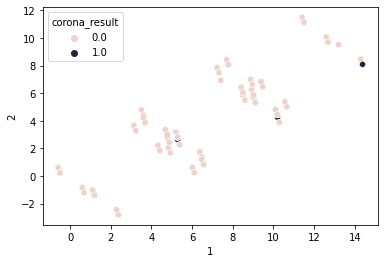

In [66]:
pca = PCA(n_components = 2)
X_pca = pd.DataFrame(data = pca.fit_transform(StandardScaler().fit_transform(X)),columns= ['1','2'])
XY_pca = pd.concat([X_pca,Y], axis=1)
plot = sns.scatterplot(x='1',y='2',data=XY_pca,hue="corona_result")


#Use a value of 120000 to see this graph

In [67]:
train_x, test_x, train_y, test_y   = train_test_split(StandardScaler().fit_transform(X), Y, test_size=0.2, random_state=0)
model = LinearSVC(multi_class = 'ovr', class_weight = 'balanced')

model.fit(train_x, train_y)

print('Accuracy of linear SVC on training set: {:.2f}'.format(model.score(train_x, train_y)))

print('Accuracy of linear SVC on test set: {:.2f}'.format(model.score(test_x, test_y)))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of linear SVC on training set: 0.89
Accuracy of linear SVC on test set: 0.89


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [68]:
#save the linear SVC model
dump(model, 'svc.pkl')

['svc.pkl']

In [69]:
train_x, test_x, train_y, test_y= train_test_split(X, Y, test_size=0.2, random_state=0)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((104500, 6), (104500, 1), (26126, 6), (26126, 1))

In [70]:
model = DecisionTreeClassifier(random_state=0)

cross_val_score(model, train_x, train_y, cv=5)

array([0.94, 0.94, 0.94, 0.94, 0.94])

In [71]:
model.fit(train_x, train_y)

print('Accuracy of decision tree on training set: {:.2f}'.format(model.score(train_x, train_y)))

print('Accuracy of of decision tree on test set: {:.2f}'.format(model.score(test_x, test_y)))

Accuracy of decision tree on training set: 0.94
Accuracy of of decision tree on test set: 0.94


In [72]:
#save the decision tree model
dump(model, 'decisionTree.pkl')

['decisionTree.pkl']

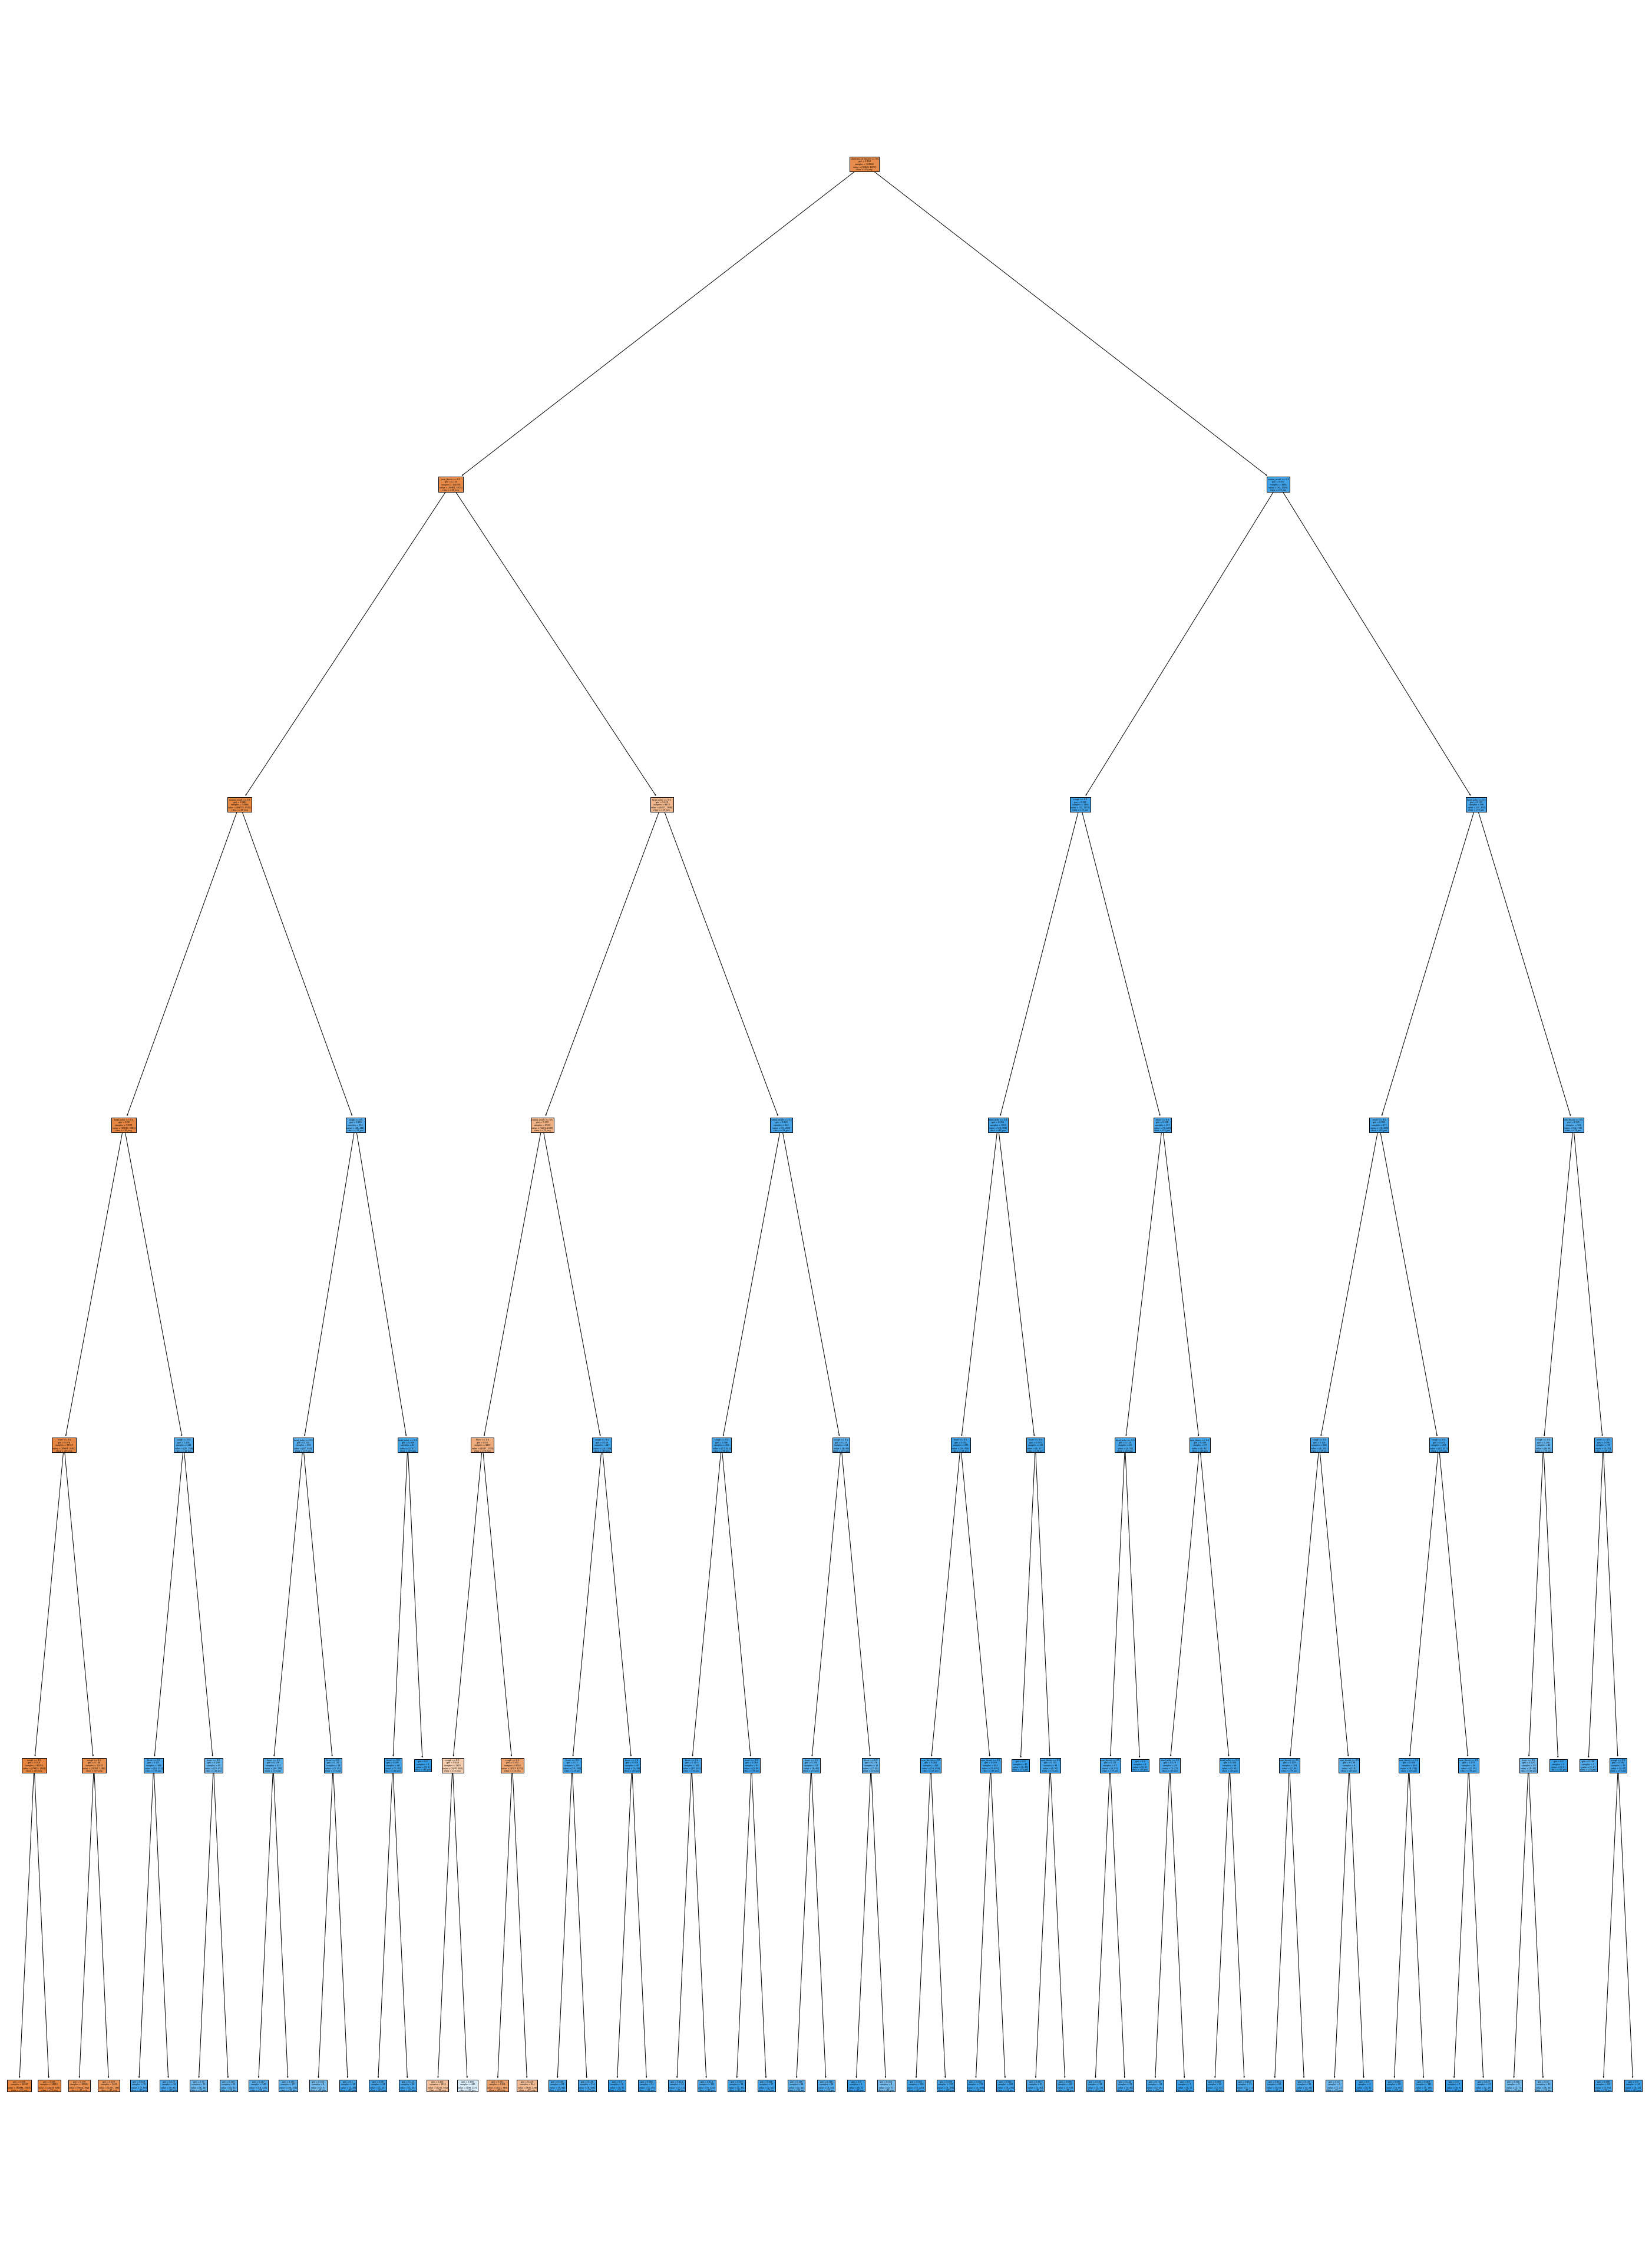

In [73]:
fig = plt.figure(figsize=(50,70))
_ = tree.plot_tree(model, feature_names=new_df.columns, class_names=["c19_neg","c19_pos"], filled=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[23888    84]
 [ 1440   714]]
Normalized confusion matrix
[[1.   0.  ]
 [0.67 0.33]]


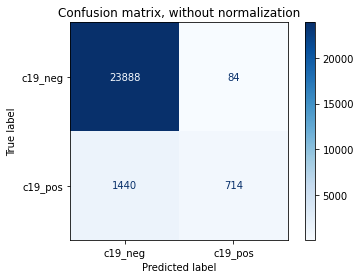

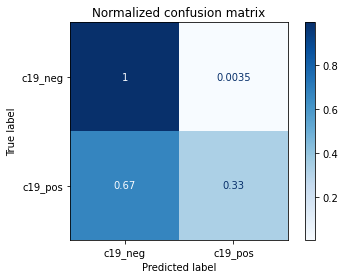

In [74]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, test_x, test_y,
                                display_labels=["c19_neg","c19_pos"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

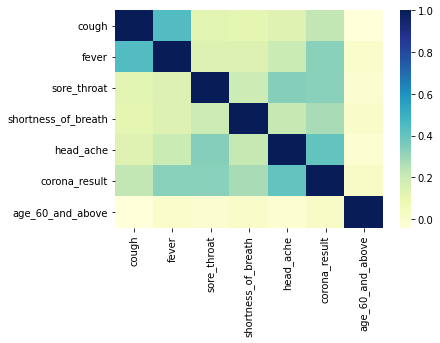

In [75]:
sns.heatmap(new_df.corr(method = 'spearman'),cmap="YlGnBu")